## 2.6 Building model with Deep Learning

#### Using Tensorflow to build model

#### Isolating Rossmann Store Sales dataset into time series data

In [2]:
# Importing Necessary Packages
import warnings
warnings.filterwarnings("ignore")

# import time
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import datetime
from pandas import Series,DataFrame
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
import os
import logging
import logging.handlers
from logging.handlers import WatchedFileHandler

# Create the directory if it doesn't exist
log_directory = "C:/Users/Suraj/Desktop/model/phermacitical_sales"
os.makedirs(log_directory, exist_ok=True)

# Construct the absolute path for the log file
log_file_path = os.path.join(log_directory, "rossman.log")

handler = WatchedFileHandler(log_file_path)
formatter = logging.Formatter(logging.BASIC_FORMAT)
handler.setFormatter(formatter)

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(handler)

# Now you can use the logger to write log messages
logger.info("This is an info log message.")

INFO:__main__:This is an info log message.


In [4]:
# Class to load the data
class FetchData():
    def __init__(self):
        self.dfdict = {}
        self.dfdict['train'] = self.get_train_data()
        self.dfdict['test'] = self.get_test_data()
        self.dfdict['store'] = self.get_store_data()

    def get_train_data(self,name='train'):
        filename = f'/content/drive/MyDrive/Deep learning/train.csv'
        try:
            df = pd.read_csv(filename)
            logging.info(f"{name} Dataset read successfully")
            return df

        except Exception as e:
            logging.exception(f" Exception occured in reading dataset, {e}")
            return None

    def get_test_data(self,name='test'):
        filename = f'/content/drive/MyDrive/Deep learning/test.csv'
        try:
            df = pd.read_csv(filename)
            logging.info(f"{name} Dataset read successfully")
            return df

        except Exception as e:
            logging.exception(f" Exception occured in reading dataset, {e}")
            return None

    def get_store_data(self,name='store'):
        filename = f'/content/drive/MyDrive/Deep learning/store.csv'
        try:
            df = pd.read_csv(filename)
            logging.info(f"{name} Dataset read successfully")
            return df

        except Exception as e:
            logging.exception(f" Exception occured in reading dataset, {e}")
            return None

In [5]:
data = FetchData()

In [6]:
try:
    train_data = data.get_train_data("/content/drive/MyDrive/Deep learning/train.csv")
    train_store_data = data.get_train_data("/content/drive/MyDrive/Deep learning/train_store_data.csv")
    test_data = data.get_train_data("/content/drive/MyDrive/Deep learning/test.csv")
    store_data=data.get_store_data("/content/drive/MyDrive/Deep learning/store.csv")

except Exception as e:
    logging.exception(f"Exception occured in loading dataset, Exception:{e}")

In [7]:
rossmann_store_sales= train_store_data.groupby("Date").agg({"Sales": "mean"})
rossmann_store_sales

,Sales
Date,
2013-01-01,87.284560
2013-01-02,6233.030493
2013-01-03,5693.112108
2013-01-04,5954.218834
2013-01-05,5337.751570
...,...
2015-07-27,9602.952466
2015-07-28,8174.953363
2015-07-29,7623.284305


In [8]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [9]:
scaler = StandardScaler()
try:

    scale = scaler.fit(rossmann_store_sales[['Sales']])
    # transform the training data column
    rossmann_store_sales['Scaled_sales'] = scale.transform(rossmann_store_sales[['Sales']])
    logging.info(f"Changing non-numeric to numeric values, successfully")

except Exception as e:
    print(e)
    logging.exception(f"Exception occured while changing non-numeric to numeric values, Exception:{e}")

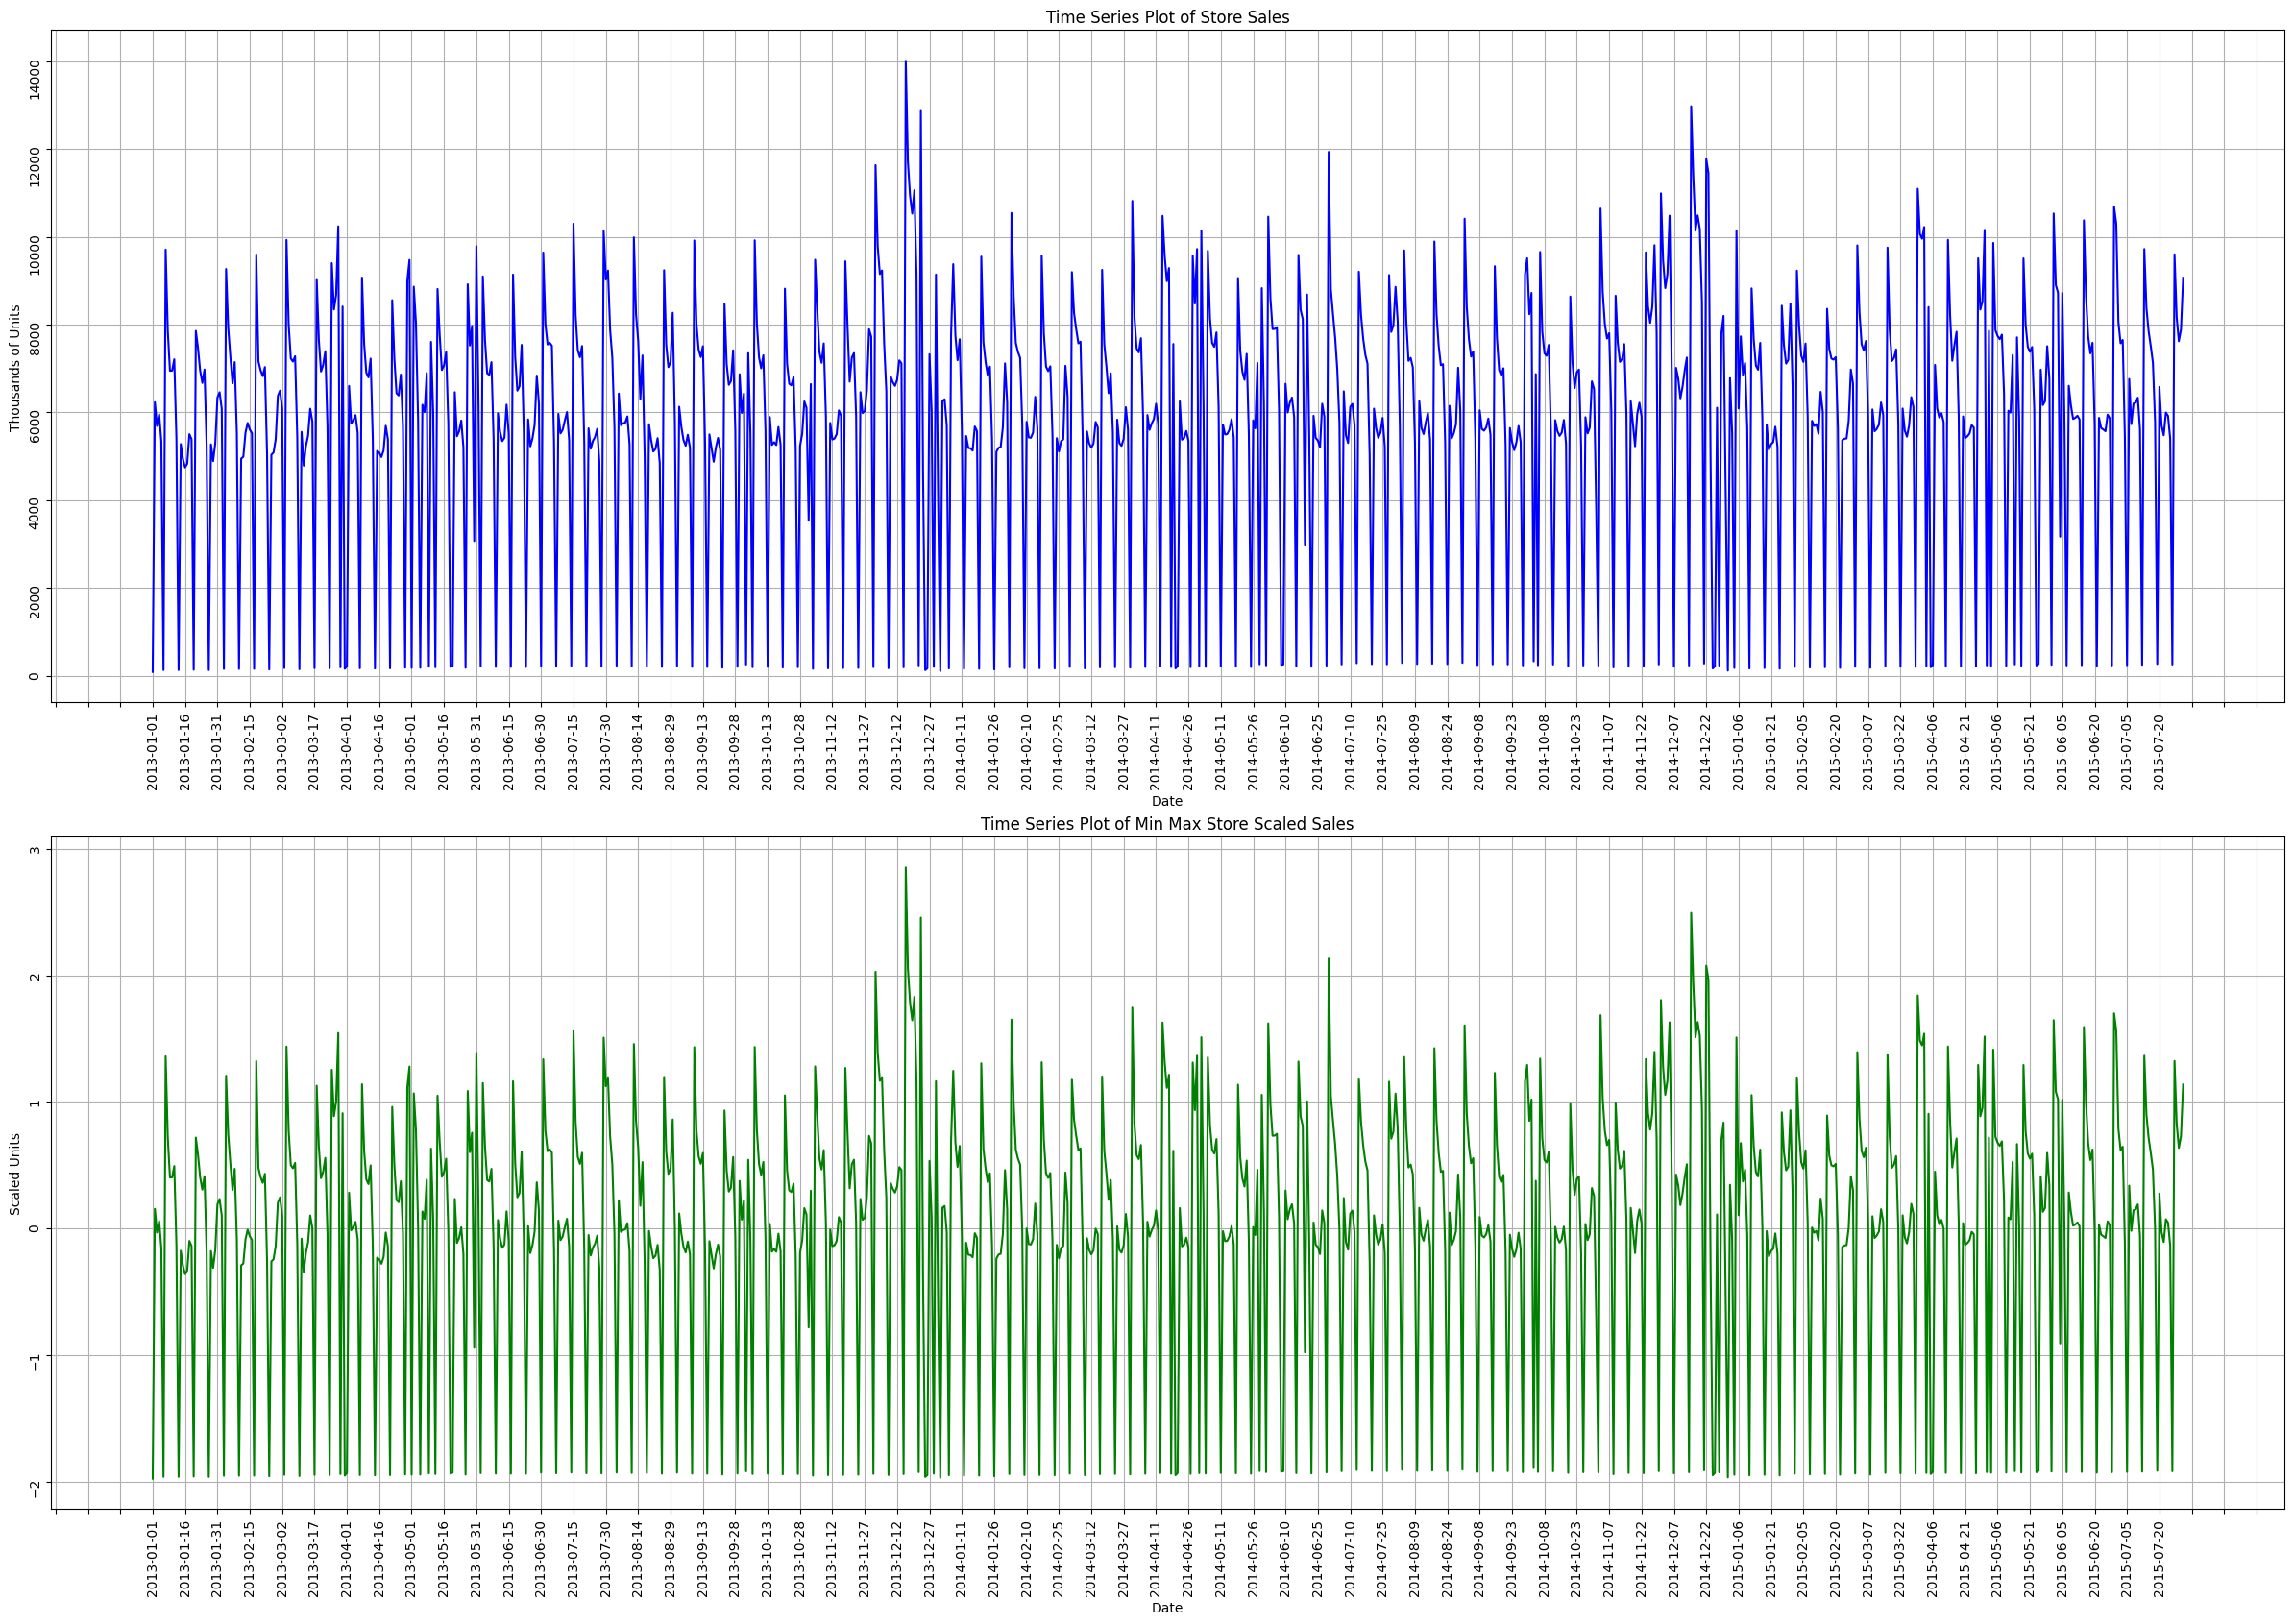

In [10]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(rossmann_store_sales.index, rossmann_store_sales.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(rossmann_store_sales.index, rossmann_store_sales.Scaled_sales, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Store Scaled Sales')
ax2.grid(True)
plt.show()

## Checking for Stationality

## Step 1: Check Stationarity Before going any further into our analysis, our series has to be made stationary

* Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation etc). if the mean of a tm increases over time, then it not stationary.

#### The mean across many time periods is only informative if the expected value is the same across time periods. If these population parameters can vary, what are we really estimating by taking an average across time?

#### Stationarity requires that the statistical properties must be the same across time, making the sample average a reasonable way to estimate them.

### Methods to Check Stationarity

#### 1 Plotting rolling statistics: plotting rolling mean and variance is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not stationary.

2 ACF and PACF plots: An autocorrelation plot (ACF) represent the autocorrelation of the series with lags of itself. A partialACF plot represent the amount of correlation beetween a series and a lag of itself that is not explained by correlations at all lower-order lags Ideally, we want no corralation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.

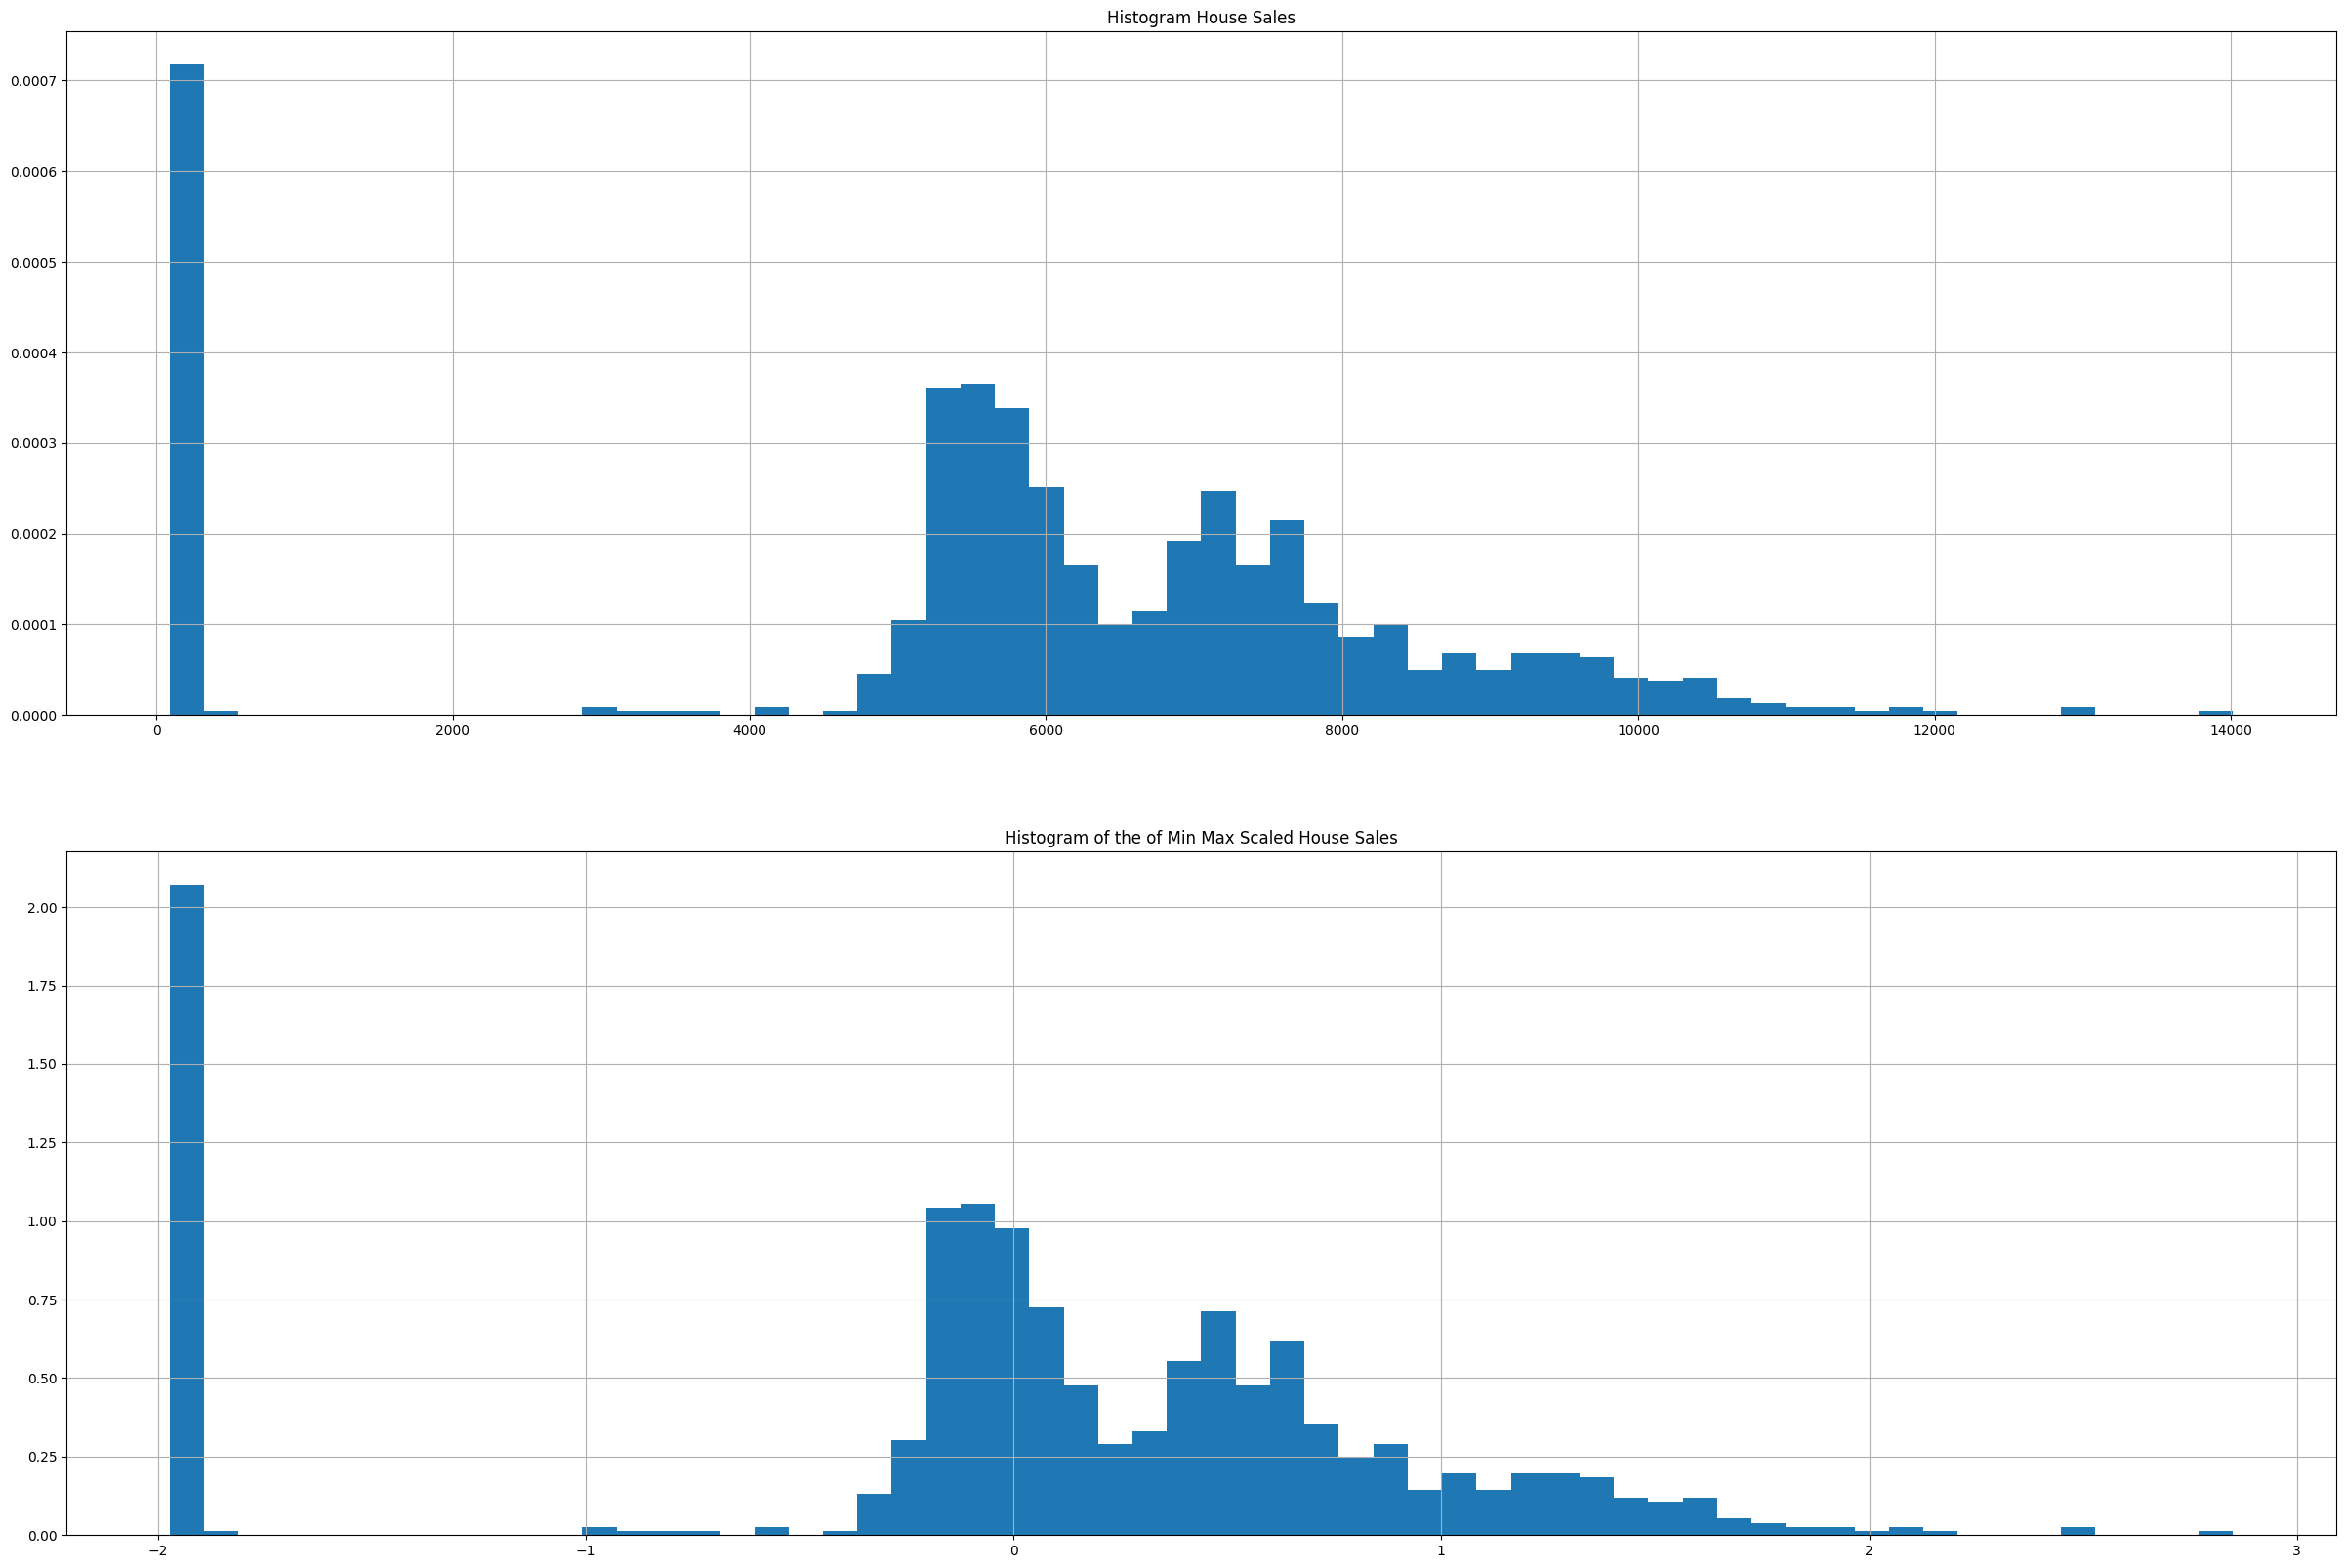

In [11]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(rossmann_store_sales.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(rossmann_store_sales.Scaled_sales, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

In [12]:
adfResult = adfuller(rossmann_store_sales.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')


ADF Statistic: -5.6508228372078975
p-value: 9.870006549261872e-07


In [13]:
SIZE = len(rossmann_store_sales.Scaled_sales)
WINDOW_SIZE = 48
# BATCH_SIZE= int(SIZE*0.8)
BATCH_SIZE = SIZE-WINDOW_SIZE*2
EPOCHS = 200


In [14]:
DateTrain = rossmann_store_sales.index.values[0:BATCH_SIZE]
DateValid = rossmann_store_sales.index.values[BATCH_SIZE:]
XTrain = rossmann_store_sales.Scaled_sales.values[0:BATCH_SIZE].astype('float32')
XValid = rossmann_store_sales.Scaled_sales.values[BATCH_SIZE:].astype('float32')

In [15]:
# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [16]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape


TensorShape([846, 1])

In [17]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [18]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [19]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [20]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [21]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [22]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [23]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [24]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

## Define and Estimate the LSTM

In [25]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533 (2.08 KB)
Trainable params: 533 (2.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:

history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 0.4096 - val_loss: 0.3982
Epoch 2/200
1/1 [==============================] - 1s 530ms/step - loss: 0.4088 - val_loss: 0.3971
Epoch 3/200
1/1 [==============================] - 1s 520ms/step - loss: 0.4081 - val_loss: 0.3959
Epoch 4/200
1/1 [==============================] - 1s 512ms/step - loss: 0.4074 - val_loss: 0.3947
Epoch 5/200
1/1 [==============================] - 1s 553ms/step - loss: 0.4068 - val_loss: 0.3934
Epoch 6/200
1/1 [==============================] - 2s 2s/step - loss: 0.4061 - val_loss: 0.3922
Epoch 7/200
1/1 [==============================] - 0s 265ms/step - loss: 0.4055 - val_loss: 0.3910
Epoch 8/200
1/1 [==============================] - 0s 266ms/step - loss: 0.4048 - val_loss: 0.3898
Epoch 9/200
1/1 [==============================] - 0s 245ms/step - loss: 0.4042 - val_loss: 0.3886
Epoch 10/200
1/1 [==============================] - 0s 254ms/step - loss: 0.4037 - val_loss: 0.3874
Epoch 11/200
1/

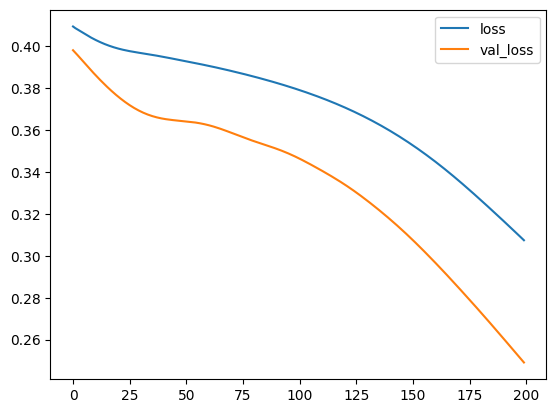

In [28]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [29]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast


In [30]:
Forecast = model_forecast(model, rossmann_store_sales.Scaled_sales.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

1/1 [==============================] - 2s 2s/step


In [31]:
def model_forecast_test(self, model):

        series = self.scaled_df["scaled_sales"].values[:, np.newaxis]

        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(self.WINDOW_SIZE, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(self.WINDOW_SIZE))
        ds = ds.batch(self.SIZE).prefetch(1)
        forecast = model.predict(ds)

        Results = forecast[self.BATCH_SIZE-self.WINDOW_SIZE:-1]
        Results1 = self.scaler_obj.inverse_transform(Results.reshape(-1,1))
        XValid1 = self.scaler_obj.inverse_transform(self.valid_sales.reshape(-1,1))

In [32]:
MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)
print(textstr)

MAE = 6068.461  RMSE = 6745.012


In [33]:
import pickle

In [34]:
# Save the model using pickle
with open('LSTM_model.pkl', 'wb') as f:
    pickle.dump(model, f)